In [1]:
#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

with open ('transaction-data-adhoc-analysis.json') as f:
    data = json.load(f)
    df = pd.DataFrame(data) #Converting the dictionary into DataFrame

#Removing other columns --- https://www.askpython.com/python-modules/pandas/remove-column-from-python-dataframe
del df["mail"]
del df["birthdate"]
del df["name"]
del df["sex"]

#Removing the numbers from the address and extracting the region; removing the day in the transaction date to leave only the year and month --- https://tutorial.eyehunts.com/python/get-last-two-characters-of-string-python-example-code/
df["address"] = df["address"].str[:-6]
df["address"] = df["address"].str[-2:]
df["transaction_date"] = df["transaction_date"].str[:-3]

#Creating a column for the order id to keep track of which transactions are together before splitting them by line item --- https://www.geeksforgeeks.org/python-pandas-series-tolist/
data_list = df["transaction_items"].tolist()
order_id = np.arange(len(data_list))
df["order_id"] = order_id

#Splitting the transaction_items into rows for each item --- https://thewebdev.info/2022/03/26/how-to-split-text-in-a-column-into-multiple-rows-with-python-pandas/
df["transaction_items"] = df["transaction_items"].str.split(";")
df = df.explode("transaction_items").reset_index(drop = True)
cols = list(df.columns)
cols.append(cols.pop(cols.index("username")))
df = df[cols]
df[["product_name","raw_item_quantity"]] = df ["transaction_items"].str.split("(",expand=True) #Splitting the transaction_items into columns for the product name and raw item quantity
df["product_name"] = df["product_name"].str[:-1] #Removing the comma at the end for all products
df["item_quantity"] = df["raw_item_quantity"].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int) #Retrieving the integer value of the raw item quantity --- https://www.pauldesalvo.com/how-to-extract-all-numbers-from-a-string-column-in-python-pandas/

#Removing other columns
del df["transaction_items"]
del df["transaction_value"]
del df["raw_item_quantity"]

#Creating a column for the price of an individual item and making the price an integer --- https://www.projectpro.io/recipes/insert-new-column-based-on-condition-in-python --- https://www.geeksforgeeks.org/convert-string-to-integer-in-python/
individual_price = []
for product_name in df["product_name"]:
    if product_name == "Candy City,Gummy Worms": individual_price.append(int("150"))
    elif product_name == "Candy City,Orange Beans": individual_price.append(int("199"))
    elif product_name == "Exotic Extras,Beef Chicharon": individual_price.append(int("1299"))
    elif product_name == "Exotic Extras,Kimchi and Seaweed": individual_price.append(int("799"))
    elif product_name == "HealthyKid 3+,Gummy Vitamins": individual_price.append(int("1500"))
    elif product_name == "HealthyKid 3+,Nutrional Milk": individual_price.append(int("1990"))
    elif product_name == "HealthyKid 3+,Yummy Vegetables": individual_price.append(int("500"))
    else: individual_price.append("NA")
df["individual_price"] = individual_price

#Creating a column for the total price of the items --- https://www.adamsmith.haus/python/answers/how-to-multiply-two-pandas-dataframe-columns-in-python
df["total_price"] = df["item_quantity"] * df["individual_price"]

#Getting the unique values and making them into an array --- https://thispointer.com/pandas-get-unique-values-in-single-or-multiple-columns-of-a-dataframe-in-python/ --- https://appdividend.com/2022/06/02/how-to-convert-python-list-to-array/
months_list = df["transaction_date"].unique()
months_array = np.array(months_list) 
product_list = df["product_name"].unique()
product_array = np.array(product_list)
address_list = df["address"].unique()
address_array = np.array(address_list)

#Creating a pivot table for the count of the item quantities based on the months and products --- https://www.statology.org/pandas-sum-column-with-condition/ --- https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/
breakdown_count = []
for m in months_array:
    for p in product_array:
        total_count = df.loc[(df["transaction_date"] == m) & (df["product_name"] == p), "item_quantity"].sum()
        individual_breakdown_count ={
            "transaction_date": m, 
            "product_name": p,
            "total_count": total_count
            }
        breakdown_count.append(individual_breakdown_count)
#Converting the list into a dataframe and creating a wide pivot table --- https://favtutor.com/blogs/list-to-dataframe-python --- https://towardsdatascience.com/reshaping-a-pandas-dataframe-long-to-wide-and-vice-versa-517c7f0995ad
bcdf = pd.DataFrame(breakdown_count)
bcdf_wide = pd.pivot(bcdf, index="product_name", columns = "transaction_date", values = "total_count")
bcdf_wide["total"] = bcdf_wide.sum(axis = 1, numeric_only = True)

#Creating a pivot table for the sum of the sales based on the months and products, converting the list into a dataframe and creating a wide pivot table
breakdown_sale = []
for m in months_array:
    for p in product_array:
        total_sale = df.loc[(df["transaction_date"] == m) & (df["product_name"] == p), "total_price"].sum()
        individual_breakdown_sale ={
            "transaction_date": m, 
            "product_name": p,
            "total_sale": total_sale
            }
        breakdown_sale.append(individual_breakdown_sale)
bsdf = pd.DataFrame(breakdown_sale)
bsdf_wide = pd.pivot(bsdf, index = "product_name", columns = "transaction_date", values = ("total_sale"))
bsdf_wide["total"] = bsdf_wide.sum(axis = 1, numeric_only = True)

#Creating a pivot table for the sum of the sales based on the address
breakdown_state = []
for a in address_array:
    total_sale_state = df.loc[df["address"] == a, "total_price"].sum()
    individual_breakdown_state ={
        "address": a, 
        "total_sale_state": total_sale_state
        }
    breakdown_state.append(individual_breakdown_state)
bstdf = pd.DataFrame(breakdown_state)
bstdf = bstdf.sort_values("total_sale_state",ascending = False)
bstdf.reset_index(drop = True, inplace = True) #Resetting the index --- https://thispointer.com/how-to-drop-index-column-of-a-pandas-dataframe/

#Creating a pivot table for the count of each customer's transactions per month
breakdown_user = pd.pivot_table(df, values = ["order_id"], index = "username", columns = "transaction_date", fill_value = 0, aggfunc = "nunique") 
breakdown_user_df = breakdown_user.reset_index()
breakdown_user_df["total"] = breakdown_user_df.sum(axis = 1, numeric_only=True)

#Identifying the top customers based on the total number of their transactions
highest_transaction_count = None
highest_transaction_count = breakdown_user_df.sort_values("total", ascending = False)

#Creating a dataframe based on the month and transactions
complete_transaction_count = []
for m in months_array:
    monthly_transaction_content = breakdown_user_df[("order_id",m)].to_numpy() #Contains only the array
    monthly_transaction = {
        "transaction_date":m,
        "order_id":monthly_transaction_content,
    } #Contains the transaction_date and the array
    complete_transaction_count.append(monthly_transaction) #Contains all the transaction_date's and the arrays
ctcdf = pd.DataFrame(complete_transaction_count) #Contains all the transaction_date's and the arrays in a table format

df = df.set_index("order_id") #Setting the dataframe index based on the order id --- https://www.delftstack.com/howto/python-pandas/pandas-remove-index/

#Making the default False
customerCount = len(complete_transaction_count[0]["order_id"]) #Counting the number of customers
purchasedStat = [False]*customerCount
repeaterStat = [False]*customerCount
inactiveStat = [False]*customerCount
engagedStat = [False]*customerCount
newStat = [False]*customerCount
oldStat = [False]*customerCount

repeaterCount = []
inactiveCount = []
engagedCount = []
newCount = []

#Iterating through all the months
i = 0
while i < len(complete_transaction_count):
    #Iterating also through all the customers for each month
    j = 0 #Indexing the customer
    while j < len(complete_transaction_count[0]["order_id"]):
        if (complete_transaction_count[i]["order_id"][j] > 0) and (purchasedStat[j] == False):
            purchasedStat[j] = True
        
        #New
        if (i == 0): #If the current month is the first month,
            if purchasedStat[j] == True:
                oldStat[j] = True
                newStat[j] = True
        if (i > 0): #If the current month is not the first month,
            if oldStat[j] == False and complete_transaction_count[i]["order_id"][j] > 0:
                oldStat[j] = True
                newStat[j] = True
            else: #Ensuring that old customers are no longer in the new customer count
                newStat[j] = False
        
        #Repeater
        if (i == 0): #If the current month is the first month,
            repeaterStat[j] = False
        if (i > 0): #If the current month is not the first month,
            #Checking if the customer has purchased in the previous AND current month
            if (complete_transaction_count[i-1]["order_id"][j] and complete_transaction_count[i]["order_id"][j]> 0): 
                repeaterStat[j] = True
            else:
                repeaterStat[j] = False

        #Inactive
        if (i == 0): #If the current month is the first month,
            inactiveStat[j] = False
        if (i > 0): #If the current month is not the first month,
            #Checking if the customer has purchased in any of the previous months AND has not purchased for the current month
            if (purchasedStat[j] == True and complete_transaction_count[i]["order_id"][j] == 0): 
                inactiveStat[j] = True
            else:
                inactiveStat[j] = False

        #Engagement
        if (i == 0): #If the current month is the first month,
            # If the customer has purchased,
            if (complete_transaction_count[i]["order_id"][j] > 0):
                engagedStat[j] = True
        if (i > 0): #If the current month is not the first month,
            #Checking if the customer has purchased in the each of the previous months AND current month
            if (complete_transaction_count[i]["order_id"][j] > 0) and (engagedStat[j] == True):
                engagedStat[j] = True
            else:
                engagedStat[j] = False
        
        j += 1 #Going through the next customer
    i += 1 #Going through the next month  
    #Placing the count for each month of each category into an array
    repeaterCount.append(repeaterStat.count(True))
    inactiveCount.append(inactiveStat.count(True))
    engagedCount.append(engagedStat.count(True))
    newCount.append(newStat.count(True))

loyaltydf = pd.DataFrame({"Month": months_array, "Repeater": repeaterCount, "Inactive": inactiveCount, "Engaged": engagedCount, "New": newCount})
loyaltydf = loyaltydf.T #Transposing the index and columns --- https://appdividend.com/2022/03/15/pandas-dataframe-transpose/
loyaltydf.columns = loyaltydf.iloc[0] #Placing the months as the header --- https://www.stackvidhya.com/replace-header-with-first-row-in-pandas/
loyaltydf = loyaltydf[1:]

In [2]:
#Displaying the organized dataframe
df

,address,transaction_date,username,product_name,item_quantity,individual_price,total_price
order_id,,,,,,,
0,AE,2022/01,veronicawells,"Exotic Extras,Beef Chicharon",4,1299,5196
1,AP,2022/01,cgilbert,"Exotic Extras,Beef Chicharon",3,1299,3897
1,AP,2022/01,cgilbert,"HealthyKid 3+,Nutrional Milk",4,1990,7960
1,AP,2022/01,cgilbert,"Candy City,Orange Beans",1,199,199
2,AP,2022/01,cgilbert,"HealthyKid 3+,Gummy Vitamins",3,1500,4500
...,...,...,...,...,...,...,...
83034,SD,2022/06,llowe,"HealthyKid 3+,Nutrional Milk",2,1990,3980
83034,SD,2022/06,llowe,"Candy City,Gummy Worms",2,150,300
83035,AE,2022/06,cmcdowell,"HealthyKid 3+,Nutrional Milk",1,1990,1990


In [3]:
#Displaying the breakdown of the monthly product count
bcdf_wide

transaction_date,2022/01,2022/02,2022/03,2022/04,2022/05,2022/06,total
product_name,,,,,,,
"Candy City,Gummy Worms",9559,9996,9986,10043,9801,9934,59319
"Candy City,Orange Beans",9774,10037,9611,9914,9964,10106,59406
"Exotic Extras,Beef Chicharon",9665,10001,9816,9890,10028,9902,59302
"Exotic Extras,Kimchi and Seaweed",9676,9949,9967,9921,9773,10104,59390
"HealthyKid 3+,Gummy Vitamins",9681,9980,10145,9842,9948,9980,59576
"HealthyKid 3+,Nutrional Milk",9727,9691,9876,9786,9881,9767,58728
"HealthyKid 3+,Yummy Vegetables",9959,10256,9896,9861,9735,9722,59429


<AxesSubplot:title={'center':'Total Quantity Sold per Product'}>

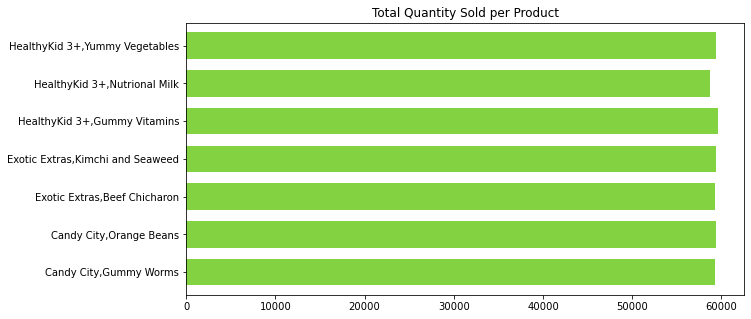

In [4]:
#Plotting the total quantity sold per product
bcdf_wide.plot(kind = "barh", xlabel = "", y = "total", width = 0.7, figsize = (10,5), color = "#83d241", legend = None, title = "Total Quantity Sold per Product")

In [5]:
#Displaying the breakdown of the monthly product sales
bsdf_wide

transaction_date,2022/01,2022/02,2022/03,2022/04,2022/05,2022/06,total
product_name,,,,,,,
"Candy City,Gummy Worms",1433850,1499400,1497900,1506450,1470150,1490100,8897850
"Candy City,Orange Beans",1945026,1997363,1912589,1972886,1982836,2011094,11821794
"Exotic Extras,Beef Chicharon",12554835,12991299,12750984,12847110,13026372,12862698,77033298
"Exotic Extras,Kimchi and Seaweed",7731124,7949251,7963633,7926879,7808627,8073096,47452610
"HealthyKid 3+,Gummy Vitamins",14521500,14970000,15217500,14763000,14922000,14970000,89364000
"HealthyKid 3+,Nutrional Milk",19356730,19285090,19653240,19474140,19663190,19436330,116868720
"HealthyKid 3+,Yummy Vegetables",4979500,5128000,4948000,4930500,4867500,4861000,29714500


In [6]:
#Displaying the total sales per state
bstdf

,address,total_sale_state
0,AE,13653879
1,AA,13435435
2,AP,12767571
3,WY,8551096
4,HI,8054049
5,OH,7692962
6,MD,7476960
7,UT,7344592
8,IL,7253269
9,VA,7217999


Text(0.5, 1.0, 'Total Sales in Tens of Millions per State')

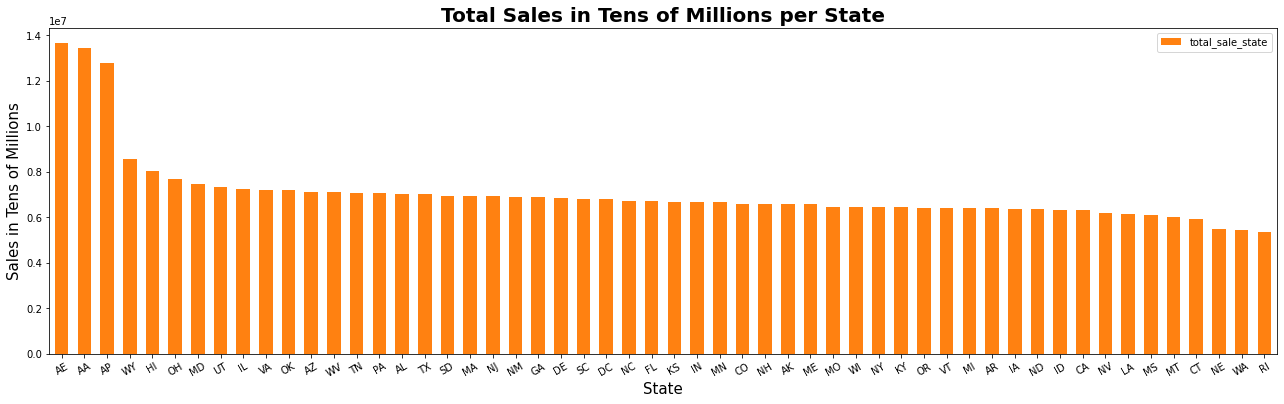

In [7]:
#Plotting the total sales per state
bstdf.plot(kind = "bar", width = 0.6, figsize=(22, 6), color = "#ff8111", x = "address")
plt.xticks(rotation=30, horizontalalignment = "center")
plt.xlabel("State", fontsize = 15)
plt.ylabel("Sales in Tens of Millions", fontsize = 15)
plt.title("Total Sales in Tens of Millions per State", fontsize = 20, fontweight = "bold")

In [8]:
#Retrieving the five states with the highest total sales --- https://note.nkmk.me/en/python-pandas-head-tail/
bstdf.head(5)

,address,total_sale_state
0,AE,13653879
1,AA,13435435
2,AP,12767571
3,WY,8551096
4,HI,8054049


Text(0.5, 1.0, 'Total Sales in Tens of Millions per State')

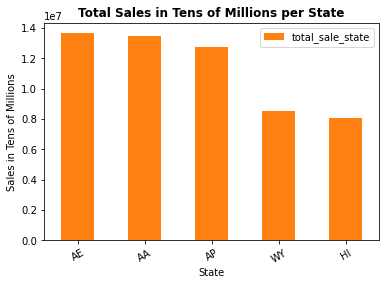

In [9]:
#Plotting the five states with the highest total sales
bstdf.head(5).plot(kind = "bar", color = "#ff8111", x = "address") 
plt.xticks(rotation=30, horizontalalignment = "center")
plt.xlabel("State")
plt.ylabel("Sales in Tens of Millions")
plt.title("Total Sales in Tens of Millions per State", fontweight = "bold")

In [10]:
#Retrieving the five states with the lowest total sales
bstdf.tail(5)

,address,total_sale_state
49,MT,6023848
50,CT,5915562
51,NE,5499784
52,WA,5428101
53,RI,5368603


Text(0.5, 1.0, 'Total Sales in Millions per State')

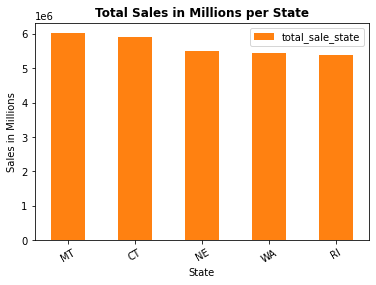

In [11]:
#Plotting the five states with the lowest total sales
bstdf.tail(5).plot(kind = "bar", color = "#ff8111", x = "address") 
plt.xticks(rotation=30, horizontalalignment = "center")
plt.xlabel("State")
plt.ylabel("Sales in Millions")
plt.title("Total Sales in Millions per State", fontweight = "bold")

In [12]:
#Displaying the number of transactions per customer per month
breakdown_user_df

username order_id                                          \
transaction_date             2022/01 2022/02 2022/03 2022/04 2022/05 2022/06   
0                    aadams        3       2       1       1       0       1   
1                  aaguilar        0       0       2       1       0       2   
2                  aalvarez        0       1       3       1       1       0   
3                   aaron02        2       1       3       3       0       2   
4                   aaron15        0       1       3       1       0       3   
...                     ...      ...     ...     ...     ...     ...     ...   
8500                zwatson        2       2       2       0       0       2   
8501                 zweber        1       1       0       2       2       1   
8502                 zwelch        2       3       1       2       2       1   
8503                 zwhite        1       3       2       0       6       6   
8504              zwilliams        1       3       3       1       0       0   

                 total  
transaction_date        
0                    8  
1                    5  
2                    6  
3                   11  
4                    8  
...                ...  
8500                 8  
8501                 7  
8502                11  
8503                18  
8504                 8  

[8505 rows x 8 columns]

In [13]:
#Retrieving the top 10 customers based on number of transactions
highest_transaction_count[:10]

username order_id                                  \
transaction_date               2022/01 2022/02 2022/03 2022/04 2022/05   
7656                   tsmith        6       9      13       8       7   
1430                   cjones        8       8      11       8       7   
8468                  zmartin        9       4       8       8      11   
8386                   ysmith        9       7       8       9       5   
2346                   esmith        5       7       9       8       8   
3854              jonesnicole        9       3       9       5       9   
8261                 xjohnson        9       8       6       9       4   
532                    asmith        9       8       6       3       7   
3994                   jsmith        6       6       4       5       6   
8491                   zsmith        7       3       7       8       8   

                         total  
transaction_date 2022/06        
7656                  10    53  
1430                  10    52  
8468                   8    48  
8386                   8    46  
2346                   7    44  
3854                   8    43  
8261                   6    42  
532                    7    40  
3994                  11    38  
8491                   3    36

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'tsmith'),
  Text(1, 0, 'cjones'),
  Text(2, 0, 'zmartin'),
  Text(3, 0, 'ysmith'),
  Text(4, 0, 'esmith'),
  Text(5, 0, 'jonesnicole'),
  Text(6, 0, 'xjohnson'),
  Text(7, 0, 'asmith'),
  Text(8, 0, 'jsmith'),
  Text(9, 0, 'zsmith')])

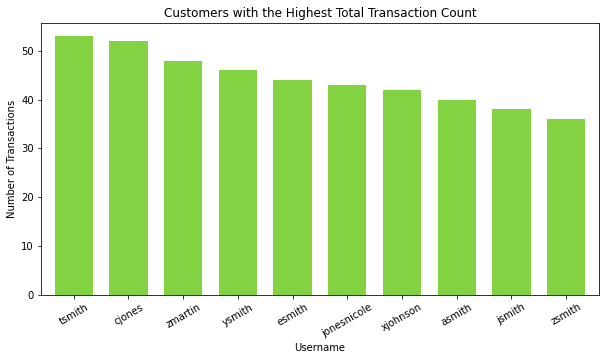

In [14]:
#Plotting the total number of transactions of the top 10 customers
highest_transaction_count[:10].plot(kind = "bar", x ="username", y = "total", xlabel = "Username", ylabel = "Number of Transactions", width = 0.7, figsize = (10,5), color = "#83d241", legend = None, title = "Customers with the Highest Total Transaction Count")
plt.xticks(rotation = 30)

In [15]:
#Displaying the number of customers based on the customer loyalty metrics
loyaltydf

Month,2022/01,2022/02,2022/03,2022/04,2022/05,2022/06
Repeater,0,5167,5239,5191,5126,5208
Inactive,0,1416,1728,1912,1915,1840
Engaged,6583,5167,4141,3304,2685,2210
New,6583,1463,340,94,22,3


Text(0.5, 1.0, 'Customer Loyalty Metrics')

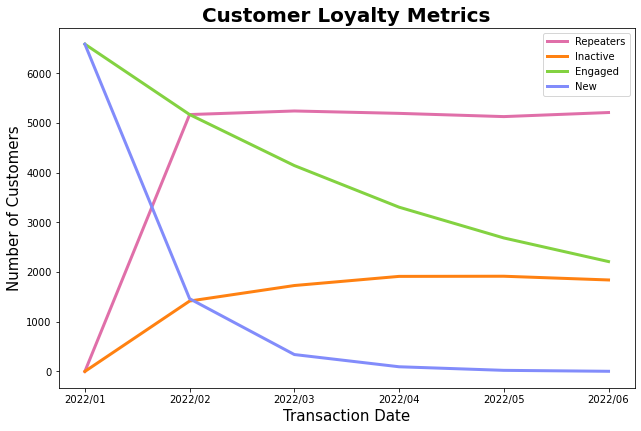

In [16]:
#Plotting the number of customers based on the customer loyalty metrics
fig=plt.figure(figsize=(8,5))
ax = fig.add_axes([0,0,1,1])
ax.plot(months_array, repeaterCount, label = "Repeaters", color = "#e06fa9", linewidth = 3)
ax.plot(months_array, inactiveCount, label = "Inactive", color = "#ff8111", linewidth = 3)
ax.plot(months_array, engagedCount, label = "Engaged", color = "#83d241", linewidth = 3)
ax.plot(months_array, newCount, label = "New", color = "#828cfb", linewidth = 3)
ax.legend()
plt.xlabel("Transaction Date", fontsize = 15)
plt.ylabel("Number of Customers", fontsize = 15)
plt.title("Customer Loyalty Metrics", fontsize = 20, fontweight = "bold")